In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, models, layers
from sklearn.model_selection import train_test_split
import wandb
from wandb.keras import WandbCallback
from matplotlib import pyplot
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
tf.config.list_physical_devices('GPU')

In [2]:
# A function to return a CNN model based on input hyperparameters
def createCNN(n_filters, filter_size, n_dense, num_conv_layers, input_shape, activation, n_output, filter_size_decay = 1, dropout_conv = 0.0, dropout_dense = 0.0, batch_normalize = False, data_augment = False):
    model = models.Sequential()
    
    if data_augment:
        data_augmentation = tf.keras.Sequential([ 
                            layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                            layers.experimental.preprocessing.RandomRotation(0.2)])
        model.add(data_augmentation)
    
    
    for ii in range(0, num_conv_layers): # Number of convolutional layers is num_conv_layers
        if ii == 0:
            if batch_normalize:
                model.add(layers.BatchNormalization(input_shape=input_shape))
            model.add(layers.Conv2D(n_filters, (filter_size, filter_size), activation=activation, input_shape=input_shape))
        else:
            if batch_normalize:
                model.add(layers.BatchNormalization())
            model.add(layers.Conv2D(n_filters, (filter_size, filter_size), activation=activation))
        model.add(layers.MaxPooling2D((2, 2)))
        if dropout_conv != 0.0:
            model.add(layers.Dropout(dropout_conv))
    
        n_filters = int(n_filters * filter_size_decay)
    
    model.add(layers.Flatten())
    model.add(layers.Dense(n_dense, activation=activation))
    if dropout_dense != 0.0:
        model.add(layers.Dropout(dropout_dense))
    model.add(layers.Dense(n_output))
    
    return model

In [ ]:
dataset_path = "../../nature_12K/inaturalist_12K"
train_path = dataset_path + "/train"
test_path = dataset_path + "/val"

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

max_shape = (32, 32, 3)

data_train = ImageDataGenerator(validation_split = 0.1)

data_test = ImageDataGenerator()

train_generator = data_train.flow(
        train_images,
        train_labels,
        subset = 'training')

validation_generator = data_train.flow(
        train_images,
        train_labels,
        subset = 'validation')

test_generator = data_train.flow(
        test_images,
        test_labels)

In [ ]:
my_model = my_cnn(16, 3, 64, (32, 32, 3), 'relu', 10)
my_model.summary()

In [3]:
dataset_path = "../../nature_12K/inaturalist_12K"
train_path = dataset_path + "/train"
test_path = dataset_path + "/val"
max_shape = (256, 256, 3)

data_train = ImageDataGenerator(validation_split = 0.1)#, rescale = 1. / 255)

data_test = ImageDataGenerator()#rescale = 1. / 255)

full_train_generator = ImageDataGenerator().flow_from_directory(
        train_path,
        class_mode='categorical')

train_generator = data_train.flow_from_directory(
        train_path,
        class_mode='categorical',
        subset = 'training')

validation_generator = data_train.flow_from_directory(
        train_path,
        class_mode='categorical',
        subset = 'validation')

test_generator = data_test.flow_from_directory(
        test_path,
        class_mode='categorical',
        shuffle = False)

Found 9999 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [ ]:
def train(model,
          optimizer,
          loss_fn,
          epochs=10):
    model.compile(optimizer=optimizer, loss=loss_fn, metrics = ['accuracy'])
    model.fit(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[WandbCallback()])

In [ ]:
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'accuracy',
        'goal': 'maximize'
    }, 'parameters' : {
              "n_filters": {'values': [32, 64]},
              "filter_size_decay" : {'values':[0.5, 1, 1.15]},
              "data_augment": {'values':[True, False]},
              "dropout" : {'values':[0.0, 0.2, 0.4]},
              "batch_normalize" : {'values':[True, False]},
              "filter_size" : {'values':[3, 5]},
              "n_dense" : {'values':[50, 100]}
        }
    }

In [ ]:
sweep_id = wandb.sweep(sweep_config, entity = '0x2e4', project = 'cs6910-a2')

In [ ]:
def run():
    default_config = {
              "n_filters": 32,
              "filter_size_decay" : 1,
              "data_augment": False,
              "dropout" : 0.0,
              "batch_normalize" : False,
              "filter_size" : 3,
              "n_dense" : 50
           }

    run = wandb.init(project='cs6910-a2', config=default_config)
    config = wandb.config

    # initialize model
    model = createCNN(n_filters = config.n_filters, filter_size = config.filter_size, n_dense = config.n_dense, num_conv_layers = 5, input_shape = max_shape, activation = 'relu', n_output = 10, filter_size_decay=config.filter_size_decay, dropout_conv = config.dropout / 3, dropout_dense = config.dropout, batch_normalize=config.batch_normalize, data_augment=config.data_augment)

    # Instantiate an optimizer to train the model.
    optimizer = tf.keras.optimizers.Nadam()
    # Instantiate a loss function.
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

    train(model,
      optimizer,
      loss_fn)

In [ ]:
wandb.agent(sweep_id, run)

In [ ]:
import random

a = [[[0 for k in range(4)] for i in range(4)] for j in range(15)]
b = [0 for k in range(15)]

for i in range(0, 15):
    for j in range(0, 4):
        for k in range(0, 4):
            a[i][j][k] = random.randint(0, 15)
    b[i] = random.randint(1, 3)

f = open('train.txt', 'w')
f.write(str(a))
f.close()
f = open('test.txt', 'w')
f.write(str(b))
f.close()

In [ ]:
import ast

f = open('train.txt', 'r')
train_s = np.asarray(ast.literal_eval(f.read()))
print(train_s)
f.close()

f = open('test.txt', 'r')
test_s = np.asarray(ast.literal_eval(f.read()))
print(test_s)
f.close()

In [ ]:
testing_model = createCNN(10, 2, 2, 3, (32, 32, 3), 'relu', 10)
testing_model.summary()

In [ ]:
testing_model.compile(optimizer='nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = testing_model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_val, y_val))

In [ ]:
model = createCNN(n_filters = 32, filter_size = 3, n_dense = 100, num_conv_layers = 5, input_shape = max_shape, activation = 'relu', n_output = 10)

In [ ]:
model.summary()

In [ ]:
# Instantiate an optimizer to train the model.
optimizer = tf.keras.optimizers.Nadam()
# Instantiate a loss function.
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

train(model,
  optimizer,
  loss_fn)

In [4]:
best_model = createCNN(n_filters = 32, filter_size = 3, n_dense = 100, num_conv_layers = 5, input_shape = max_shape, activation = 'relu', n_output = 10, filter_size_decay = 1.15, data_augment = True)
best_model.compile(optimizer = tf.keras.optimizers.Nadam(), loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])
best_model.fit(full_train_generator, epochs=10)

Epoch 1/10
313/313 [==============================] - 211s 674ms/step - loss: 3.0297 - accuracy: 0.1694
Epoch 2/10
313/313 [==============================] - 174s 555ms/step - loss: 2.1485 - accuracy: 0.2108
Epoch 3/10
313/313 [==============================] - 150s 479ms/step - loss: 2.0714 - accuracy: 0.2521
Epoch 4/10
313/313 [==============================] - 149s 476ms/step - loss: 2.0189 - accuracy: 0.2736
Epoch 5/10
313/313 [==============================] - 153s 489ms/step - loss: 1.9925 - accuracy: 0.2890
Epoch 6/10
313/313 [==============================] - 153s 489ms/step - loss: 1.9561 - accuracy: 0.3075
Epoch 7/10
313/313 [==============================] - 158s 503ms/step - loss: 1.9400 - accuracy: 0.3108
Epoch 8/10
313/313 [==============================] - 155s 496ms/step - loss: 1.9090 - accuracy: 0.3229
Epoch 9/10
313/313 [==============================] - 157s 501ms/step - loss: 1.8919 - accuracy: 0.3282
Epoch 10/10
313/313 [==============================] - 151s 483m

In [ ]:
best_model.summary()

In [6]:
y_pred_l = best_model.predict(test_generator)
y_pred = y_pred_l.argmax(axis=1)

In [7]:
# Printing the accuracy 
y_true = np.array([np.zeros(200) + ii for ii in range(0, 10)]).flatten()
(y_pred == y_true).sum() / 2000

0.3175

wandb: Currently logged in as: 0x2e4 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


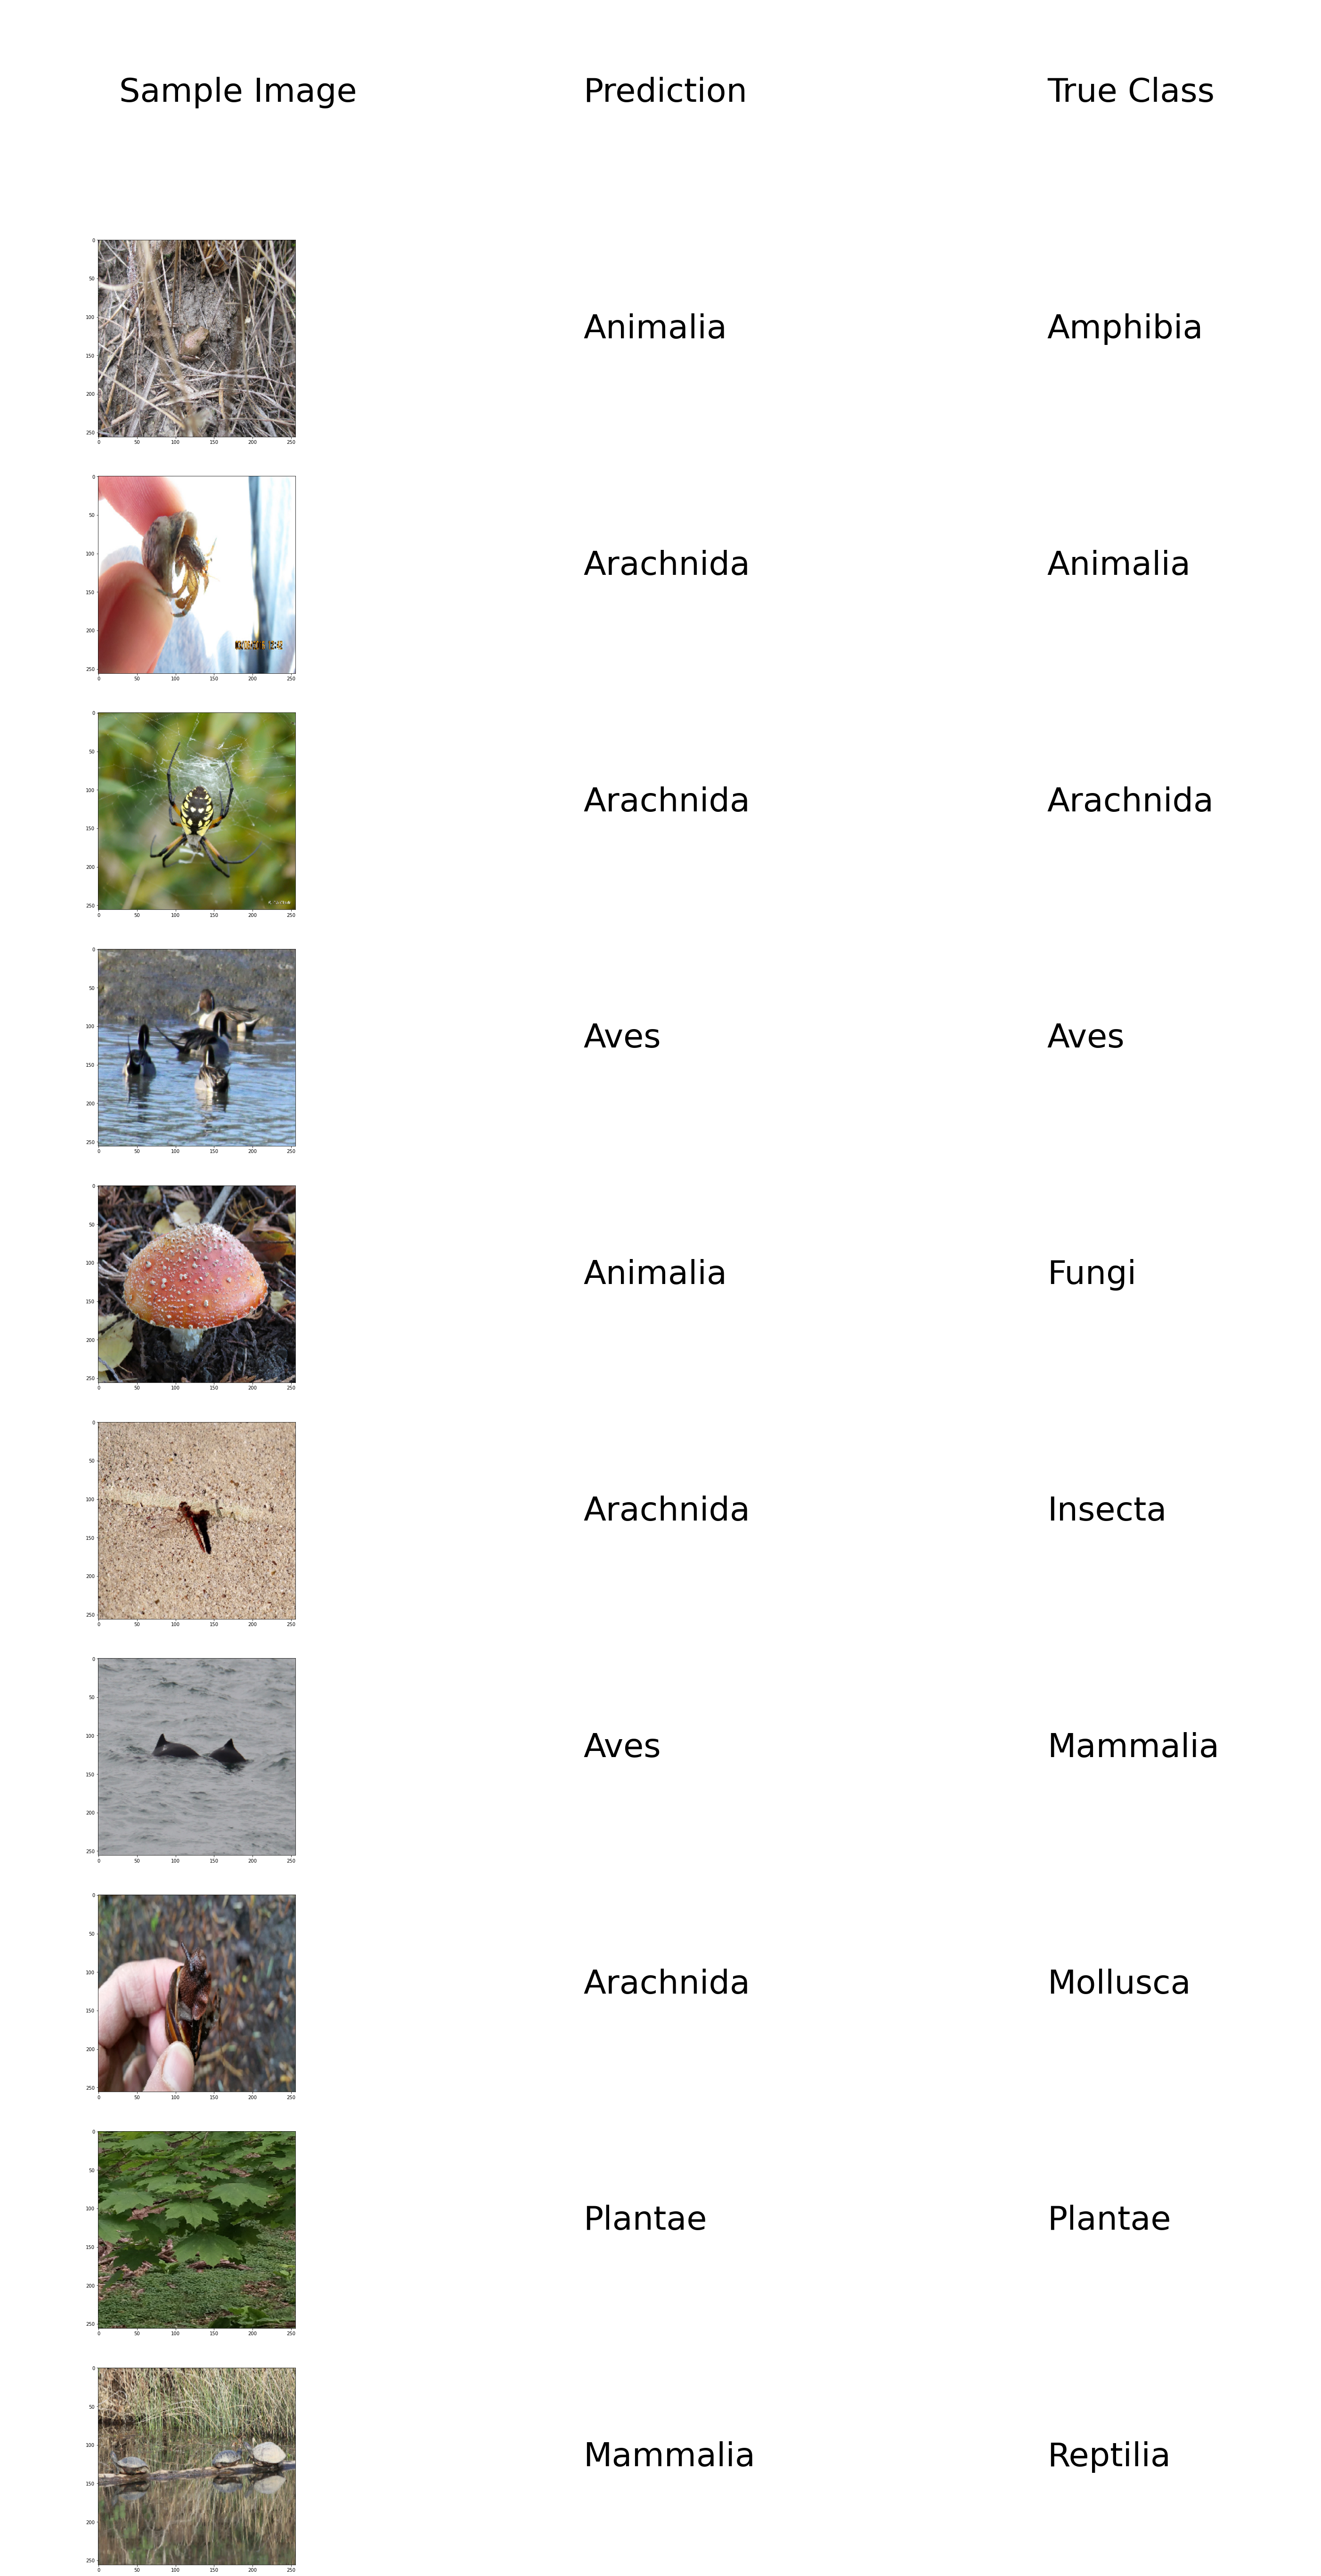

In [31]:
pyplot.figure(figsize=[50, 100])
all_classes = list(test_generator.class_indices.keys())

ax = pyplot.subplot(11, 3, 1)
ax1 = pyplot.subplot(11, 3, 2)
ax2 = pyplot.subplot(11, 3, 3)
ax.axis('off')
ax.text(0.3, 0.5, "Sample Image", fontsize=70)
ax1.axis('off')
ax1.text(0.3, 0.5, "Prediction", fontsize=70)
ax2.axis('off')
ax2.text(0.3, 0.5, "True Class", fontsize=70)

for some in os.listdir(test_path):
    idx = test_generator.class_indices[some]
    new_path = test_path + "/" + some
    img_path = new_path + "/" + os.listdir(new_path)[0]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size = (max_shape[0], max_shape[1]))
    img_np = np.asarray(img)
    ax = pyplot.subplot(11, 3, 3 * idx + 4)
    ax1 = pyplot.subplot(11, 3, 3 * idx + 5)
    ax2 = pyplot.subplot(11, 3, 3 * idx + 6)
    ax.imshow(img_np)
    ax1.axis('off')
    ax1.text(0.3, 0.5, all_classes[y_pred[200 * idx]], fontsize=70)
    ax2.axis('off')
    ax2.text(0.3, 0.5, some, fontsize=70)

wandb.init(project = 'cs6910-a2')
wandb.log({'Sample Predictions' : pyplot})

In [ ]:
cat_path = train_path + "/Mammalia/26b7e18a07cb0fb7576b5019c2ea1577.jpg"
cat_np = np.asarray(tf.keras.preprocessing.image.load_img(cat_path, target_size = (max_shape[0], max_shape[1])))
cat_np = np.expand_dims(cat_np, axis=0)

filter_vis = models.Sequential()
filter_vis.add(best_model.layers[1])
result = filter_vis.predict(cat_np)

In [ ]:
pyplot.figure(figsize=[50, 100])

for ii in range(8):
    for jj in range(4):
        ax = pyplot.subplot(8, 4, 4 * ii + jj + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        pyplot.imshow(result[0, :, :, ii * 4 + jj])

wandb.init(project = 'cs6910-a2')
wandb.log({'Filters Visualization' : pyplot})

In [ ]:
@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
    return tf.nn.relu(x), grad

guided_bp_model = [tf.keras.models.Model(
    inputs = [best_model.inputs],
    outputs = [best_model.get_layer("conv2d_4").output[:, :, :, ii]]
) for ii in range(0, 10)]

layers = [[each for each in guided_bp_model[ii].layers[1:] if hasattr(each,'activation')] for ii in range(0, 10)]
for every in layers:
    for layer in every:
        if layer.activation == tf.keras.activations.relu:
            layer.activation = guidedRelu

grads = []
for ii in range(0, 10):
    with tf.GradientTape() as g:
        inputs = tf.cast(cat_np, tf.float32)
        g.watch(inputs)
        outputs = guided_bp_model[ii](inputs)
    grads.append(np.asarray(g.gradient(outputs,inputs)[0]).copy())

In [ ]:
grads

In [ ]:
for ii in range(0, 10):
    grads[ii] -= grads[ii].mean()
    grads[ii] /= (grads[ii].std() + tf.keras.backend.epsilon())
    grads[ii] = (grads[ii] * 0.25) + 0.5
    grads[ii] = np.clip(grads[ii], 0, 1) * 255
    grads[ii] = grads[ii].astype('uint8')

In [ ]:
pyplot.imshow(cat_np[0])

In [ ]:
pyplot.figure(figsize=[50, 100])
for ii in range(0, 10):
    ax = pyplot.subplot(10, 1, ii + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    pyplot.imshow(np.flip(np.array(grads[ii]),-1))

wandb.init(project = 'cs6910-a2')
wandb.log({'Guided Backpropagation' : pyplot})

In [28]:
list(test_generator.class_indices.keys())

['Amphibia',
 'Animalia',
 'Arachnida',
 'Aves',
 'Fungi',
 'Insecta',
 'Mammalia',
 'Mollusca',
 'Plantae',
 'Reptilia']